### Import Necessary Module and Set Path 

# Comparison of UNF-ST&DARDS database

## This notebook assesses the `value` of thte UNF-ST&DARDS database by comparing the results obtained with the full database (isotopic composition, etc) and the restuls obtained with using an average recipe (depletion calculations done with average enrichment and burnup).

## We used Cyclus, the agent-based fuel cycle simulator, to couple the UNF-ST&DARDS datbase to output UNF as defined by the database (time, composition, mass)

## The database used is the 1-year cooling data, which evaluated all UNF one year after its discharge from core. To be fair, we used the evaluation date of the assembly, which is when the isotopics are evaluated, not the discharge date.

## The average burnup and enrichment is listed below. The method to finding the average values are in `generate_avg_recipe.ipynb`.
* Burnup: 36,169.38 MWD/MTHM
* Enrichment: 3.392 % U-235


In [57]:
import sqlite3 as lite
import matplotlib.pyplot as plt
import os
from scipy import stats
import sys
import numpy as np
import collections
from pyne import nucname
sys.path.insert(0, '../../transition-scenarios/scripts/')
jupyter_directory = os.getcwd()
from IPython.display import Image

In [32]:
import analysis as an

In [33]:
def annual_sum(timeseries):
    """ Annual sum timeseries"""
    output = np.zeros(len(timeseries) // 12)
    for i in range(len(timeseries)):
        if i // 12 == len(timeseries) // 12:
            continue
        output[i // 12] += timeseries[i]
    return output
        

# 1. RECIPE

In [34]:
# get sqlite cursor and simulation time data
cur = an.get_cursor('recipe.sqlite')
init_year, init_month, duration, timestep = an.get_timesteps(cur)
monthly_step = init_year + timestep/12
yearly_step = np.arange(init_year, init_year + timestep[-1]/12, 1)[:-1]


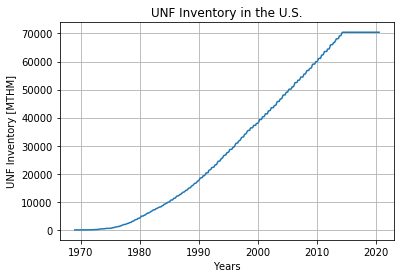

In [49]:
# Fuel Discharged - cumulative

reactors = an.get_agent_ids(cur, 'udb_reactor')
fuel_discharge_cum = an.facility_commodity_flux(cur, reactors, ['fuel'], True, True)
plt.plot(monthly_step, fuel_discharge_cum['fuel'])
plt.xlabel('Years')
plt.ylabel('UNF Inventory [MTHM]')
plt.title('UNF Inventory in the U.S.')
plt.grid()
plt.show()
plt.close()

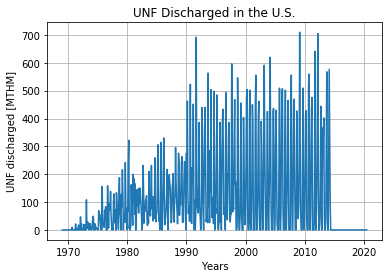

In [36]:
# Fuel Discharged - per timestep (month)

reactors = an.get_agent_ids(cur, 'udb_reactor')
fuel_discharge = an.facility_commodity_flux(cur, reactors, ['fuel'], True, False)
plt.plot(monthly_step, fuel_discharge['fuel'])
plt.xlabel('Years')
plt.ylabel('UNF discharged [MTHM]')
plt.title('UNF Discharged in the U.S.')
plt.grid()
plt.show()
plt.close()

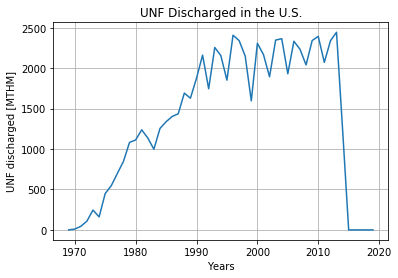

In [37]:
# Fuel Discharged - Annual sum
annual = annual_sum(fuel_discharge['fuel'])
plt.plot(yearly_step, annual)
plt.xlabel('Years')
plt.ylabel('UNF discharged [MTHM]')
plt.title('UNF Discharged in the U.S.')
plt.grid()
plt.show()
plt.close()

In [40]:
# get isotopics - this might take a while...
# Fuel Discharged - per timestep (month)

reactors = an.get_agent_ids(cur, 'udb_reactor')
iso_discharge = an.facility_commodity_flux_isotopics(cur, reactors, ['fuel'], True, False)
iso_discharge_cum = an.facility_commodity_flux_isotopics(cur, reactors, ['fuel'], True, True)

In [61]:
# how much of UNF is Pu-239?
frac = np.array(iso_discharge_cum['Pu239']) / np.array(fuel_discharge_cum['fuel'])
print('There is %f %% of Pu-239 in UNF' %stats.mode(frac)[0][0])

There is 0.007583 % of Pu-239 in UNF


/home/teddy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


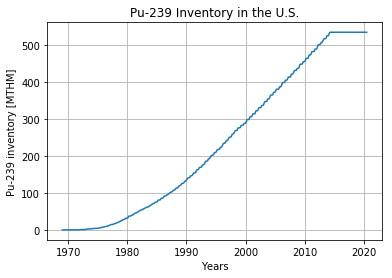

In [62]:
pu_239_buildup = iso_discharge_cum['Pu239']

plt.plot(monthly_step, pu_239_buildup)
plt.xlabel('Years')
plt.ylabel('Pu-239 inventory [MTHM]')
plt.title('Pu-239 Inventory in the U.S.')
plt.grid()
plt.show()
plt.close()

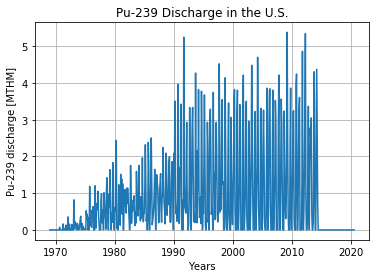

In [63]:
# since all compositions are the same, it follows 
pu_239_discharge = iso_discharge['Pu239']

plt.plot(monthly_step, pu_239_discharge)
plt.xlabel('Years')
plt.ylabel('Pu-239 discharge [MTHM]')
plt.title('Pu-239 Discharge in the U.S.')
plt.grid()
plt.show()
plt.close()

# CYCLUS DECAY

Cyclus has three decay modes - never, lazy, and manual (ref: http://fuelcycle.org/user/input_specs/control.html?highlight=control ).
* never: no decay at all.
* manual: decays material only when the facility archetype does it
* lazy: decays material when archetype / agents `look at` a composition (transactions)

I used the lazy decay, since this required no modification to the source code. To utilize it, I set up the simulation so that at the very last timestep (December of 2019), all the UNF in the storage facility is sent to a sink. Then, I look at the UNF composition in the sink.

In [45]:
# amount sent to sink at last timestep
sink_agentid = an.get_agent_ids(cur, 'sink')
total_unf_mass = cur.execute('SELECT quantity, qualid FROM transactions '
                             'INNER JOIN resources ON resources.resourceid = '
                             'transactions.resourceid WHERE receiverid = %s' %sink_agentid[0]).fetchall()
# only one transaction is made, thus we can use total_unf_mass[0]
print('TOTAL MASS AT THE END IS: %s MTHM' %total_unf_mass[0]['quantity'])

TOTAL MASS AT THE END IS: 70426607.32655999


In [82]:
# get composition
composition = cur.execute('SELECT nucid, massfrac FROM compositions WHERE qualid = %s' %total_unf_mass[0]['qualid']).fetchall()
final_comp_dict = {}
for row in composition:
    iso_name = nucname.name(row['nucid'])
    massfrac = row['massfrac']
    final_comp_dict[iso_name] = massfrac

In [80]:
# multiply the composition by the massfrac
# unit in kg
total_unf_isotopics = {}
for key, value in final_comp_dict.items():
    mass = total_unf_mass[0]['quantity'] * value
    # filter less than 100?
    if mass < 1000:
        continue
    total_unf_isotopics[key] = mass
    print('%s: %f' %(key, mass))

Rb85: 1503.507555
Sr90: 23139.692183
Zr90: 15574.904857
Zr93: 60932.444737
Tc99: 61788.600030
Pd106: 6519.750415
Pd107: 19206.537833
Sn126: 1726.022275
I129: 12887.821222
Cs135: 34272.963251
Cs137: 56976.923912
Ba134: 7670.751476
Ba137: 36376.942559
Nd144: 9573.265573
Sm147: 10112.343389
Gd154: 1707.821257
U234: 14601.344811
U235: 700769.266861
U236: 307457.056152
U238: 68071959.269395
Np237: 41228.920679
Pu238: 14203.971379
Pu239: 533767.107935
Pu240: 190841.078397
Pu241: 46448.100450
Pu242: 42373.071407
Am241: 85229.700151
Am243: 10942.619276
Cm244: 1856.610768


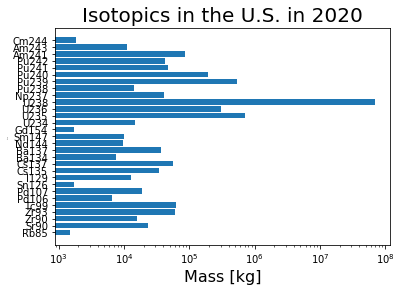

In [81]:
# plot this 

plt.barh(list(total_unf_isotopics.keys()),list(total_unf_isotopics.values()), log=True)
#plt.yticks(pos, city)
plt.xlabel('Mass [kg]', fontsize=16)
plt.ylabel('Isotope', fontsize=1)
plt.title('Isotopics in the U.S. in 2020',fontsize=20)
plt.show()

In [ ]:
# short lived vs long lived
# MA and non MA